# Биоразнообразие vs DHI: разведочный анализ-2

Цель документа -- визуализировать зависимости между биоразнообразием и DHI, найти типичные шаблоны в пространственном размещении.

Это документ продолжение [первой части](https://176.9.38.120/cruncher/notebooks/DHI/DHI_biodiversity.ipynb), в которой анализировался файл, содержащий DHI, рассчитанный по "сырым" данным fpar. В этом документе анализируются данные, содержащие DHI, рассчитанные по сглаженным данным.

Тут проделываются все те же действия, но на обновленых данных.

## Беглый взгляд на данные

Данные хранятся в файле `DATA/wwf_globe_all_biomes_filtered_dhi.csv`, прочитаем его:

In [1]:
points = read.table('DATA/wwf_globe_all_biomes_filtered_dhi.csv', header = TRUE, sep=",")

### Описательная статистика:

Получим краткую сводку по содержанию столбцов (минимум, 1-й квартиль, медиана, среднее, 3-й квартиль и максимум):

In [2]:
summary(points)

       X                 Y                CID          AMPHIBIANS   
 Min.   :-179.87   Min.   :-55.255   Min.   :    1   Min.   :  0.0  
 1st Qu.: -62.71   1st Qu.:  1.047   1st Qu.: 7517   1st Qu.:  2.0  
 Median :  33.62   Median : 39.007   Median :15030   Median :  6.0  
 Mean   :  22.99   Mean   : 29.114   Mean   :15010   Mean   : 13.1  
 3rd Qu.: 100.18   3rd Qu.: 56.833   3rd Qu.:22527   3rd Qu.: 16.0  
 Max.   : 179.63   Max.   : 79.990   Max.   :30000   Max.   :131.0  
   BIRDS_glob      MAMMTERR_g       REPTILES_g        dhi_fpar1     
 Min.   :  3.0   Min.   :  0.00   Min.   :  0.000   Min.   :   6.0  
 1st Qu.:128.0   1st Qu.: 30.00   1st Qu.:  1.000   1st Qu.: 832.5  
 Median :188.0   Median : 45.00   Median :  5.000   Median :1441.5  
 Mean   :209.8   Mean   : 57.96   Mean   :  9.884   Mean   :1652.6  
 3rd Qu.:272.0   3rd Qu.: 68.00   3rd Qu.: 14.000   3rd Qu.:2221.0  
 Max.   :611.0   Max.   :200.00   Max.   :105.000   Max.   :4137.0  
   dhi_fpar2       dhi_fpar3      

### Описание столбцов с данными.

**Общая информация:**

Каждая строка таблицы (запись) представляет собой одну точку на поверхности Земли в которой были замеряны определенные параметры. Всего имеется 30 тысяч точек.

 * CID: Идентификатор записи.
 * X: Долгота.
 * Y: Широта.
 
**Биоразнообразие:**

 * AMPHIBIANS: Показатель, характеризующий биоразнообразие амфибий.
 * BIRDS_glob: Показатель, характеризующий биоразнообразие птиц.
 * MAMMTERR_g: Показатель, характеризующий биоразнообразие наземных млекопитающих.
 * REPTILES_g: Показатель, характеризующий биоразнообразие рептилий.

 
**Показатели продуктивности:**

Данные DHI -- специальные индексы, основанные на показателе продуктивности FPAR (Fraction of Absorbed Photosynthetically Active radiation) -- это доля солнечного излучения, поглощенного растительной биомассой, измеряется в процентах. Индексы `dhi*` расчитаны по сырым рядам dhi, индексы `avg*` - по сглаженным.

 * dhi_fpar1, avg_dhi_1: DHI для FPAR. Куммулятивная продуктивность: рассчитывается суммированием FPAR за год (интеграл).
 * dhi_fpar2, avg_dhi_2: DHI для FPAR. Минимальная продуктивность: минимальное значение FPAR за год.
 * dhi_fpar3, avg_dhi3: DHI для FPAR. Сезонность: расчитывается как отношение стандартного отклонения FPAR к его среднему значению (за год). Таким образом большая величина dhi_fpar3 означает большое колебание продутивности в течении года.
 
 
*Примечание 1.* Отсутсвующие данные из предыдущего файла по биоразнообразию уже отфильтрованы.
 
*Примечание 2.* Отсутвтующие данные для DHI из предыдущего файла уже отфильтрованы.

Построим графики парных распределений для DHI, рассчитанных по сырым и фильтрованным данным: 

In [2]:
# Небольшая выборка данных, для удобства работы. Используется для быстрой оценки, чтобы не ждать 
# результатов работы на большой выборке
pdata = points[c("dhi_fpar1", "dhi_fpar2", "dhi_fpar3", "avg_dhi_1", "avg_dhi_2", "avg_dhi_3")]
psample_ind = sample(1:length(pdata[, 1]), size=1000)
psample = points[psample_ind, ]

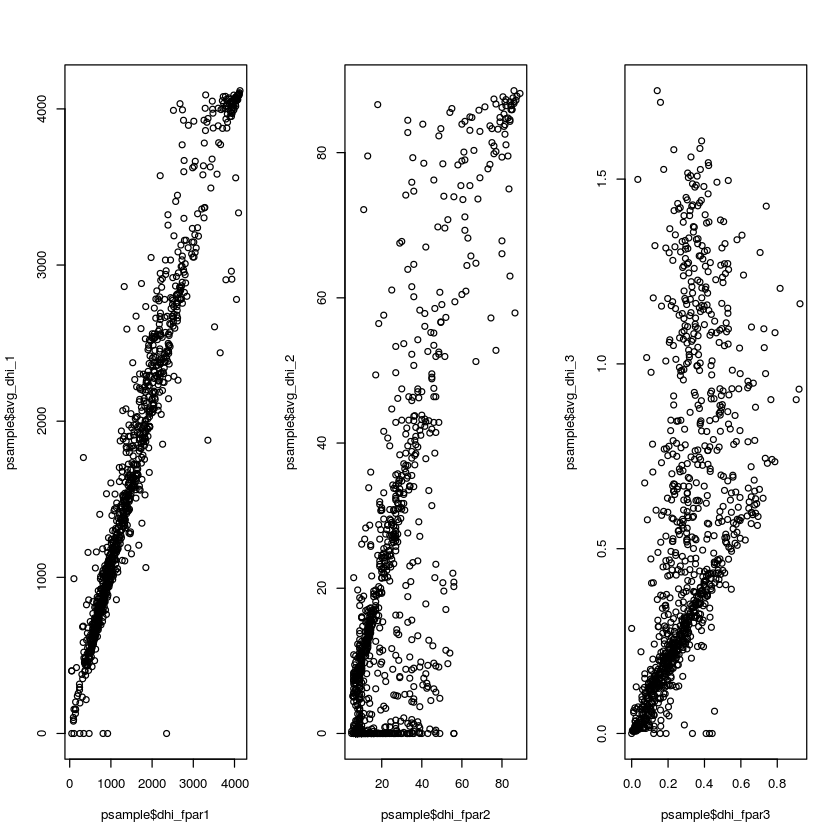

In [4]:
par(mfrow=c(1,3))
plot(psample$dhi_fpar1, psample$avg_dhi_1)
plot(psample$dhi_fpar2, psample$avg_dhi_2)
plot(psample$dhi_fpar3, psample$avg_dhi_3)

На графике видно, что в среднем куммулятивная и минимальная продуктивности в новых данных выше, а сезонность ниже. При этом часть новых данных сбросилась в ноль. Этот ноль объясняется тем, что DHI точек, попадающих в пустыни, воду, города и т.п. был насильственно сброшен до нулевого состояния (ранее они могли быть выше нуля из-за атмосферных эффектов и/или из-за естесственног ненулевого фона, например, в городах).

Выбросим старые данные DHI, а также вспомогательные поля.

In [3]:
points = points[
    c("CID", "X", "Y", "AMPHIBIANS", "BIRDS_glob", "MAMMTERR_g", 
      "REPTILES_g", "avg_dhi_1", "avg_dhi_2", "avg_dhi_3")]

# Число оставшихся точек:
length(points$X)

[1] 23269

## Исследование структуры данных

### Совместное распределение, корреляции

Итак, у нас есть набор точек, лежащих в 7-ми мерном пространстве, система координат которого состоит из семи осей: "AMPHIBIANS", "BIRDS_glob", "MAMMTERR_g", "REPTILES_g", "dhi_fpar1", "dhi_fpar2", "dhi_fpar3" (географические координаты пока не учитываем, возможно, введем их в анализ позднее). 

Построим графики взаимного расположения точек.

In [6]:
png("img/all_vars_filtered_dhi.png", width=728, height=728, units="px")
 pairs(~AMPHIBIANS+BIRDS_glob+MAMMTERR_g+REPTILES_g+avg_dhi_1+avg_dhi_2+avg_dhi_3, 
       data=points, pch = 19, cex=0.01, main="Scatterplot Matrix")
dev.off()

png 
  2

<img src="https://176.9.38.120/cruncher/files/DHI/img/all_vars_filtered_dhi.png">

По сравнению с аналогичным графиком на предыдущих данных становятся более четкими зависимости между компонентами DHI (но это, так сказать, побочный эффект).

Что же касается зависимости между биоразнообразием и DHI, то бросается в глаза, что характерные особенности (например, треугольная форма зависимостей между птицами/млекопитающими и dhi3) становятся более выраженными.

Расчитаем корреляции:

In [7]:
data_for_cor = points[
    c("AMPHIBIANS", "BIRDS_glob", "MAMMTERR_g", 
      "REPTILES_g", "avg_dhi_1", "avg_dhi_2", "avg_dhi_3")]
cor(data_for_cor)

,AMPHIBIANS,BIRDS_glob,MAMMTERR_g,REPTILES_g,avg_dhi_1,avg_dhi_2,avg_dhi_3
AMPHIBIANS,1.0000000,0.8158147,0.8386276,0.4744978,0.6541237,0.7214596,-0.4950621
BIRDS_glob,0.8158147,1.0000000,0.9091805,0.5450962,0.6620416,0.7026078,-0.6067372
MAMMTERR_g,0.8386276,0.9091805,1.0000000,0.5212821,0.6684141,0.7184224,-0.5420869
REPTILES_g,0.4744978,0.5450962,0.5212821,1.0000000,0.4755354,0.5811263,-0.5040993
avg_dhi_1,0.6541237,0.6620416,0.6684141,0.4755354,1.0000000,0.8889956,-0.5666026
avg_dhi_2,0.7214596,0.7026078,0.7184224,0.5811263,0.8889956,1.0000000,-0.6868753
avg_dhi_3,-0.4950621,-0.6067372,-0.5420869,-0.5040993,-0.5666026,-0.6868753,1.0000000


### Исследование структуры данных

Попробуем визуализировать данные методом [самоорганизующихся карт Кохонена](https://goo.gl/oc7YRl). Это позволит подробнее взглянуть на структуру и зависимости переменных.

#### Строим карту Кохонена

In [4]:
# Подключкаем библиотеку
library("kohonen")

Loading required package: class
Loading required package: MASS


Нормируем данные, чтобы все переменные вносили приблизительно равный вклад в результат.

In [5]:
pdata = points[c("AMPHIBIANS", "BIRDS_glob", "MAMMTERR_g", "REPTILES_g", "avg_dhi_1", "avg_dhi_2", "avg_dhi_3")]
pdata.sc = scale(pdata)

seed = 777      # Для того, чтобы можно было воспроизвести результаты, 
set.seed(seed)  # установим начальное значение для генератора случайных чисел

psample_ind = sample(1:length(pdata[, 1]), size=1000)
psample = points[psample_ind, ]
psample.sc = pdata.sc[psample_ind, ]

Определим относительные размеры сетки (отношение ширины к высоте). Для этого используем отображение Сэммона: https://en.wikipedia.org/wiki/Sammon_mapping

Initial stress        : 0.04596
stress after   1 iters: 0.04535


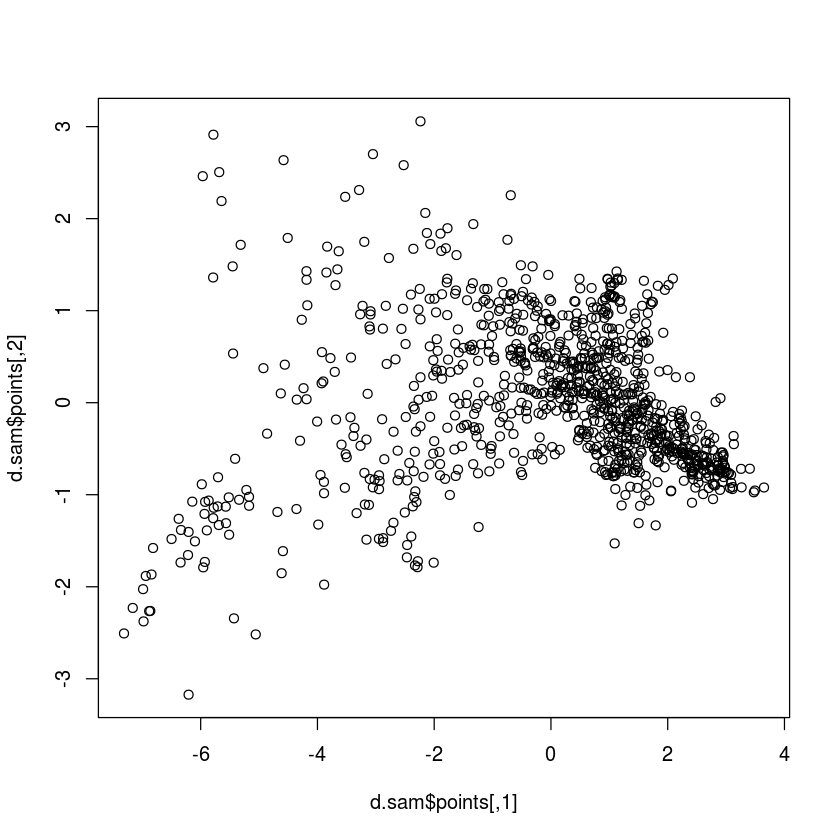

In [10]:
d.u = unique(psample.sc)
d.matr = dist(d.u)
d.sam = sammon(d.matr)
plot(d.sam$points)

Видим, что проекция выборки точек на плоскость занимает (грубо) 9 условных единиц, а по высоте около 5. Соотношение несколько поменялось, но учитывая, что в прошлый раз мы создавали чуть более длинную сетку, чем нужно, то оставим соотношение 4x7.

Построим сеть:

In [6]:
row = 4
col = 7

seed = 111      # Для того, чтобы можно было воспроизвести результаты, 
set.seed(seed)  # установим начальное значение для генератора случайных чисел

grd = somgrid(col, row, "hexagonal")

d.som = som(data = as.matrix(pdata.sc), 
            grid = grd, 
            rlen=5000
)

summary(d.som)

som map of size 7x4 with a hexagonal topology.
Training data included; dimension is 23269 by 7
Mean distance to the closest unit in the map: 0.5725972


#### Строим графики полученных карт.

(если смотреть графики в отдельном окне, то они выглядят крупнее)

In [8]:
png("img/som_filtered_dhi.png", width=2048, height=1024, units="px")
# svg("img/som_filtered_dhi.svg")
 plot(d.som)
dev.off()

png 
  2

<img src="https://176.9.38.120/cruncher/files/DHI/img/som_filtered_dhi.png">

Построим график числа точек, которые лежат в районе узлов сетки:

In [13]:
png("img/som_count_filtered_dhi.png", width=2048, height=1024, units="px")
  plot(d.som, type='count')
dev.off()

png 
  2

<img src="https://176.9.38.120/cruncher/files/DHI/img/som_count_filtered_dhi.png">

Построим график среднего расстояния от точек, связанных с узлом сети, до этого узла:

In [14]:
png("img/som_distance_filtered_dhi.png", width=2048, height=1024, units="px")
  plot(d.som, type='quality')
dev.off()

png 
  2

<img src="https://176.9.38.120/cruncher/files/DHI/img/som_distance_filtered_dhi.png">

#### Беглый обзор карты Кохонена

Рассмотрим карту Кохонена.

Как видим, на построенной карте видны определенные закономерности. Например, в левом верхнем углу находятся узлы сети, которые лежат в области точек с высокими значениями биоразнообразия всех, кроме рептилий. Биоразнообразие рептилий отражено в узлах, лежащих чуть ниже. В правой части сети находятся узлы, лежащие в области точек с высокой сезонностью (нижняя правая часть) или с низкими значениями всех переменных.

В общих чертах построенная карта повторяет основные выводы, полученные ранее:
 
 * Если в точке высокая сезонность, то биоразнообразие низкое.
 * Если в точке низкие куммулятивная и минимальная продуктивности, то биразнообразие низкое.
 
Правда, есть класс 18, который несколько выбивается из общей картины -- при низких продуктивностях почти среднее значение биоразнообразия птиц и животных. Нужно изучить этот класс отдельно.

#### Экспорт результатов для представления на карте

Экспортируем результаты и посмотрим их на карте. Т.е. для каждой точки из исходной таблицы мы пропишем номер класса, в который она попала, и сохраним в новый файл.

Вспомогательные функции, переводят номер класса в номер строки и столбца:

In [15]:
rnum = function(i, row, col){
    1 + (i-1) %/% col
}
cnum = function(i, row, col){
    x = (i %% col)
    if (x == 0)
        col
    else
        x
}
        
row.nums = sapply(d.som$unit.classif, rnum, row=4, col=8)
col.nums = sapply(d.som$unit.classif, cnum, row=4, col=8)

Экспорт результатов:

In [16]:
result = points

result$class = d.som$unit.classif
result$row = row.nums
result$col = col.nums

write.csv('classification_filtered_dhi.csv', x=result)

### Анализ полученных классов в географическом пространстве

Результат классификации был экспортирован сюда: http://kolesov.nextgis.com/resource/88/display. Подпись к точкам - это номер класса, который был ей присвоен. Я постарался сделать так, чтобы цвет точки отражал номер класса, но результат не очень. Лучше верить надписи, чем цвету.

Кром того, классы несколько изменились, если сравнивать с предыдущим вариантом карты Кохонена, поэтому нельзя считать номера классов полностью идентичными.

Для удобства работы, чтобы не листать блокнот, скопирую сюда полученную карту Кохонена. И запишу номера классов узлов карты (номера полученных классов). Нумерация классов идет слева направо сверху вниз, т.е. левый нижний угол карты Кохонена имеет номер 1, а правый верхний - 28.

```
 22    23    24    25    26    27    28
    15    16    17    18    19    20    21
 8      9    10    11    12    13    14
    1      2     3    4      5     6     7
```

<img src="https://176.9.38.120/cruncher/files/DHI/img/som_filtered_dhi.png">

#### Пустыни и полупустыни.

*Центральная Австралия.* Как и ранее, видим, что в центральной части континента преобладает класс номер 28. Также встречается класс номер 27, хотя и несколько реже. 

*Юго-западная Африка (западная часть Намбии).* Преобладающие классы 28 и 21.

*Сахара и Аравийский полуостров.* На большую часть этих территорий данных нет. Там же, где встречаются точки -- класс 28.

Итак, в пустыни попадают класс 28, 27, 21. Эти классы характеризуются низкими значениями всех трех компонент DHI. Биоразнообразие видов или отсутствует (класс 28), или очень низок (классы 27, 21).

#### Саванны и редколесья

 *Саванны Африки.* В Африке два пояса саванн: 
 * пояс, проходящий южнее Сахары, содержит классы номер 10, 16, 18;
 * пояс, лежащий в северной части ЮАР, восточной части Намбии содержит классы 10, 16, 18.
 
*Индостан.* Большая часть Индостана (за ислкючением западного побережья и северо-восточных районов) лежит в этом поясе. Преимущественный класс - 19. Содержится также класс 12, но значительно реже.

*Центральная часть Бразилии.* Классы 15, 24, 1, 10. Эти классы идут полосами, почти не смешиваясь между собой.

*Северо-Восточная часть Автралии.* Классы 20, 27, 21.

Итак, саваны и редколесья представлены большим числом классов, чем пустыни. Это классы 1, 10, 15, 16, 18, 19, а также классы, встречаемые в пустынях: 28, 27, 20.

Классы характеризуются высокой сезонностью (на прошлых данных сезонность местами была высокой) и довольно большим разбросом в биоразнообразии. Классы 10, 16, 18 -- среднее или пониженное биоразнообразие со срденими или пониженными продуктивностями. Австралийские классы скорее характерны для пустынь, чем для саванн. Класс 19 (Индия) - пониженное значение биоразнообразия и продуктивностей (с продуктивностями странно). Бразилия - довольно высокая продуктивность и биоразнообразие. 

Таким образом относительно цельная картина для саванн и редколесий, полученная на прошлых данных, тут "развалилась" на части.

#### Влажные экваториальные леса

*Центральная Африка.* Представлен классами 1, 2, 15.

*Бассейн Амазонки.* Представлен классами 1 и 15.

*Индонезия.* Западная часть почти исключительно класс номер 8, на востоке - 3-й.

Классы 1 и 15 - высокая продуктивность, отсутсвие сезонности, высокое биоразнообразие животных и птиц (у 15-го еще и амфибий). Второй класс - высокая продуктивность, среднее биоразнообразие. Класс номер 8 - высокие продуктивности, высокое биоразнообразие рептилий, среднее биоразнообразие животных и птиц.

#### Хвойные леса

*Западная Сибирь.* Характеризуется сочетанием классов 14, 13, 5 приблизительно в равных пропорциях, на севере -- класс 6.

*Север США, юг Канады.* Преобладание классов 4, 5, 13.

Классы 14, 13 характеризуются низким биоразнообразием при пониженной продуктивности и средневыраженной сезонности. Класс 5 -- низкое биоразнообразие при средней куммулятивной продкутивности и пониженной минимальной продуктивности, слабой сезонности. Класс 6 -- очень высокая сезонность и очень низкое биоразнообразие.

### Предварительный вывод

Ранее было замечено, что:

 * Если область характеризуется большой сезонностью -- биоразнообразия там не будет.
 * Если область характеризуется малой куммулятивной продуктивностью -- биоразнообразия там не будет.

Как мы видели ранее, большая куммулятивная продуктивность и малая сезонность еще не означают автоматически высокого биоразнообразия. Посмотрим, что изменилось после перехода на сглаженные данные DHI.

Найдем класс, который отличается высокой куммулятивной продуктивностью, малой сезонностью и малым биоразнообразием. Наиболее ярковыраженный представитель - это класс номер 4; похожи на него номер 4 и номер 17. Но возьмем за основу 3-й класс. У третьего класса приблизительно 300 точек-представителей (см. раздел "Карта Кохонена"). Посмотрим, где выделенные классы расположены на карте: http://kolesov.nextgis.com/resource/88/display?base=osm-mapnik&lon=119.6191&lat=-22.1060&angle=0&zoom=4&styles=89. Оказывается, что основная часть точек расположена в восточной части Индонезии, Новой Зеландии, южной части Австралии с Тасманией, западное побережье США (севернее Сан-Франциско), Чили. Если брать в расчет 4-й класс, то точки третьего и четвертого класса будут идти вперемешку в западной и юго-западной Европе, Кубе, южной Японии, юго-восток Канады. 

По данным "сырых" и сглаженных DHI совпадают в основном Чили, Индонезия, Австралия и Новая Зеландия. Зато глядя на те территории, которые появились (с учетом 4-го фактора), можно предположить, что основной фактор все-таки не горная местность, а антропогенное воздействие.

Следующий шаг, который нужно сделать, - подложить растр плотности населения проанализировать совместное распределение DHI, биоразнообразия и плотности населения. (А еще лучше поискать карту освоенности территорий, вероятно, она даст больше информации)